# Some words at first
The book doesn't cover much of this topic. Many of the contents of accelerated linear algebra are actually more on the underlying architecture, such as the underlying XLA architecture of Tensorflow, and many frameworks are not that much relevant to python. (Content related to accelerated numerical linear algebra computation is more often written in faster languages such as C++.) 

In the process of preparing the share I investigated many resources, and this sharing is mainly to inspire interested students to continue learning related knowledge, not an exhaustive cover.

In [45]:
import jax.numpy as jnp
from jax import grad, vmap, jit
import jax

import numpy as np
from sklearn.datasets import make_blobs, make_moons
from sklearn.svm import SVC

import matplotlib.pyplot as plt
from tqdm import tqdm

We saw performance speedup achieved with a single line of code changed using the function transformation, jit. However complicated the functions you are working with are, if they are JAX-compatible, you can simply pass them through jit to enjoy the benefits of JIT compilation.

Through week 3's lecture, we have explored several powerful techniques to accelerate our machine learning pipeline: automatic differentiation, JIT compilation, etc. You can refer to week 3's notebook if you don't remember very well. :)

In today's section, we will first look at another valuable feature of JAX – automatic vectorization.

# Automatic Vectorization in JAX

In the previous section we discussed JIT compilation via the `jax.jit` function. This notebook discusses another of JAX's transforms: vectorization via `jax.vmap`.

You might remember from our discussions on NumPy that the library is efficient at applying numerical operations to all elements in an array or the elements along specific axes. By exploiting the fact that the same operation is to be applied to multiple elements, the library optimizes low-level code that performs the operation, making the computation much more efficient than doing the same thing via an iterative loop. This process is
called vectorization.

JAX addresses this concern by providing a function transformation that automatically vectorizes a given function, even if the function is only designed to take in single-valued variables (which means traditionally, an iterative loop would be necessary). 


## First Way: Manual Vectorization

Consider the following simple code that computes the convolution of two one-dimensional vectors:

In [46]:
x = jnp.arange(5)
w = jnp.array([2., 3., 4.])

def convolve(x, w):
    output = []
    for i in range(1, len(x)-1):
        output.append(jnp.dot(x[i-1:i+2], w))
    return jnp.array(output)

convolve(x, w)

DeviceArray([11., 20., 29.], dtype=float32)

Suppose we would like to apply this function to a batch of weights `w` to a batch of vectors `x`.

In [47]:
xs = jnp.stack([x, x])
ws = jnp.stack([w, w])

The most naive option would be to simply loop over the batch in Python:

In [48]:
def manually_batched_convolve(xs, ws):
    output = []
    for i in range(xs.shape[0]):
        output.append(convolve(xs[i], ws[i]))
    return jnp.stack(output)

manually_batched_convolve(xs, ws)

DeviceArray([[11., 20., 29.],
             [11., 20., 29.]], dtype=float32)

This produces the correct result, however it is not very efficient.

In order to batch the computation efficiently, you would normally have to rewrite the function manually to ensure it is done in vectorized form. This is not particularly difficult to implement, but does involve changing how the function treats indices, axes, and other parts of the input.

For example, we could manually rewrite `convolve()` to support vectorized computation across the batch dimension as follows:

In [49]:
def manually_vectorized_convolve(xs, ws):
    output = []
    for i in range(1, xs.shape[-1] -1):
        output.append(jnp.sum(xs[:, i-1:i+2] * ws, axis=1))
    return jnp.stack(output, axis=1)

manually_vectorized_convolve(xs, ws)

DeviceArray([[11., 20., 29.],
             [11., 20., 29.]], dtype=float32)

Such re-implementation is messy and error-prone; fortunately JAX provides another way.

## In JAX: Automatic Vectorization

In JAX, the `jax.vmap` transformation is designed to generate such a vectorized implementation of a function automatically:

In [50]:
auto_batch_convolve = jax.vmap(convolve)

auto_batch_convolve(xs, ws)

DeviceArray([[11., 20., 29.],
             [11., 20., 29.]], dtype=float32)

It does this by tracing the function similarly to `jax.jit`, and automatically adding batch axes at the beginning of each input.

If the batch dimension is not the first, you may use the `in_axes` and `out_axes` arguments to specify the location of the batch dimension in inputs and outputs. These may be an integer if the batch axis is the same for all inputs and outputs, or lists, otherwise.

In [51]:
auto_batch_convolve_v2 = jax.vmap(convolve, in_axes=1, out_axes=1)

xst = jnp.transpose(xs)
wst = jnp.transpose(ws)

auto_batch_convolve_v2(xst, wst)

DeviceArray([[11., 11.],
             [20., 20.],
             [29., 29.]], dtype=float32)

`jax.vmap` also supports the case where only one of the arguments is batched: for example, if you would like to convolve to a single set of weights `w` with a batch of vectors `x`; in this case the `in_axes` argument can be set to `None`:

In [52]:
batch_convolve_v3 = jax.vmap(convolve, in_axes=[0, None])

batch_convolve_v3(xs, w)

DeviceArray([[11., 20., 29.],
             [11., 20., 29.]], dtype=float32)

## Combining transformations

As with all JAX transformations, `jax.jit` and `jax.vmap` are designed to be composable, which means you can wrap a vmapped function with `jit`, or a JITted function with `vmap`, and everything will work correctly:

In [53]:
jitted_batch_convolve = jax.jit(auto_batch_convolve)

jitted_batch_convolve(xs, ws)

DeviceArray([[11., 20., 29.],
             [11., 20., 29.]], dtype=float32)

# Automatic vectorization for efficient kernels

In this section, we will see how to use automatic vectorization by going through the process of kernelizing our predictive model.

# Data that is not linearly separable
Remember that the predictive model we previously assumed in week 3 that the target we'd like to predict for can be expressed as a linear combination of the data features; the model is thus a linear one. This assumption is quite restrictive in practice, as data can present highly nonlinear and still meaningful patterns. You can refer to the make_blobs function described in week 3's notes.

To generate another toy dataset and visualize it, here we use the make_moons function from the same datasets module of scikit-learn.

# Non-linearly separable data

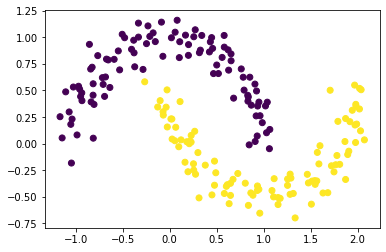

In [54]:
X, y = make_moons(n_samples=200, noise=0.1, random_state=0)
X = np.hstack((X, np.ones_like(y).reshape(-1, 1)))
y[y == 0] = -1

plt.scatter(X[:, 0], X[:, 1], c=y);

Once again, this is a binary classification problem where we need to distinguish between the yellow and the dark blue points. 

# The kernel method in machine learning
Without going into much technical detail, the kernel method (sometimes referred to as the kernel trick) refers to the process of transforming a low-dimensional dataset, such as ours, that is nonlinear to higher dimensions, with the hope that in higher dimensions, linear hyperplanes that separate the data will exist.

To take a data point to higher dimensions, additional features are created from the features already included in the original data. For instance, polynomials that are up to degree 2 for features x and y include xy and x^2.

We will then fit our predictive model on additional features. While the predictive model remains in the same form as linear regression, the data features that the model learns from are nonlinear, so the resulting decision boundary will also be nonlinear.

# Kernelized SVM

In [55]:
def linear_kernel(x, z):
    return jnp.dot(x, z)

lengthscale = 0.3

# the radial basis function, or RBF kernel, which is defined as follows:
# K(x, x') = exp(−(x-x')^2 / l)
def rbf_kernel(x, z):
    return jnp.exp(- jnp.linalg.norm(x - z) ** 2 / lengthscale)

def predict(alphas, X_test):
    return jnp.dot(vec_kernel(X, X_test), alphas)

def loss(alphas):
    preds = predict(alphas, X)
    return jnp.mean(jnp.clip(1 - jnp.multiply(y, preds), a_min=0))

In [63]:
kernel = rbf_kernel
# Here we get the vectorized form of our kernel function along the first axis (remember the kernel has two inputs) 
# with vmap(kernel, (0, None), and then vectorizing that kernel along the second axis with: vmap(vmap(kernel, (0, None)), (None, 0)). 
# Finally, we derive the JIT-compiled version of the function with jit.
vec_kernel = jit(vmap(vmap(kernel, (0, None)), (None, 0)))  # just like before 

np.random.seed(0)
alphas = np.random.randn(y.size)

In [57]:
n_iters = 200
lr = 0.01
loss_grad = jit(grad(loss))

losses = np.zeros(n_iters)
pbar = tqdm(range(n_iters))

for i in range(n_iters):
    grads = loss_grad(alphas)
    alphas = alphas - lr * grads

    tmp_loss = loss(alphas)
    losses[i] = tmp_loss

    pbar.set_postfix({'loss': tmp_loss})
    pbar.update()

    if tmp_loss == 0:
        break

pbar.close()


  0%|                                                | 0/200 [22:33:13<?, ?it/s]

 47%|███████████▊             | 94/200 [00:00<00:00, 523.14it/s, loss=0.5216542]


 94%|██████████████████████▋ | 189/200 [00:00<00:00, 632.97it/s, loss=0.2885332]


100%|████████████████████████| 200/200 [00:00<00:00, 531.69it/s, loss=0.2725643]


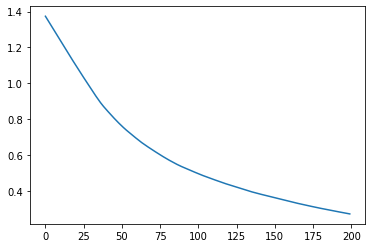

In [58]:
plt.plot(losses);

In [59]:
x_min = X[:, 0].min()
x_max = X[:, 0].max()
y_min = X[:, 1].min()
y_max = X[:, 1].max()

n_steps = 100

x_test_grid = np.linspace(x_min, x_max, n_steps)
y_test_grid = np.linspace(y_min, y_max, n_steps)

X1_test, X2_test = np.meshgrid(x_test_grid, y_test_grid, indexing='ij')
X_test = np.hstack((
    X1_test.reshape(-1, 1), 
    X2_test.reshape(-1, 1), 
    np.ones((n_steps ** 2, 1))
))

preds = predict(alphas, X_test)

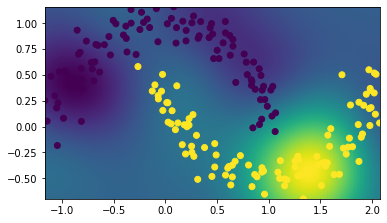

In [60]:
plt.imshow(
    preds.reshape(n_steps, n_steps).T, 
    extent=[x_min, x_max, y_min, y_max],
    origin='lower'
)

plt.scatter(X[:, 0], X[:, 1], c=y);

See the figure above. We visualize the predictions made by the model itself. We show these predictions made on a fine grid that spans across our training data points, where the colors show the predicted classes, and the hues show the confidence in the predictions

Here, the speed we achieve is roughly 160 iterations per second. To once again see how big a speedup the JIT compiler offers our program, we remove the jit() function calls from the implementation of our model:

## Non-JIT version for comparison

In [61]:
kernel = rbf_kernel
vec_kernel = vmap(vmap(kernel, (0, None)), (None, 0))

np.random.seed(0)

alphas = np.random.randn(y.size)

In [62]:
n_iters = 200
lr = 0.01
loss_grad = grad(loss)

losses = np.zeros(n_iters)
pbar = tqdm(range(n_iters))

for i in range(n_iters):
    grads = loss_grad(alphas)
    alphas = alphas - lr * grads

    tmp_loss = loss(alphas)
    losses[i] = tmp_loss

    pbar.set_postfix({'loss': tmp_loss})
    pbar.update()

    if tmp_loss == 0:
        break

pbar.close()

100%|████████████████████████| 200/200 [00:01<00:00, 144.74it/s, loss=0.2725643]


This time without JIT, the speed drops to 47 iterations per second.

# Some extensions

# 1. Parallel Evaluation in JAX

In this section we will discuss the facilities built into JAX for single-program, multiple-data (SPMD) code.

SPMD refers to a parallelism technique where the same computation (e.g., the forward pass of a neural net) is run on different input data (e.g., different inputs in a batch) in parallel on different devices (e.g., several TPUs).

Conceptually, this is not very different from vectorisation, where the same operations occur in parallel in different parts of memory on the same device. We have already seen that vectorisation is supported in JAX as a program transformation, `jax.vmap`. JAX supports device parallelism analogously, using `jax.pmap` to transform a function written for one device into a function that runs in parallel on multiple devices.

## Colab TPU Setup

If you're running this code in Google Colab, be sure to choose *Runtime*→*Change Runtime Type* and choose **TPU** from the Hardware Accelerator menu. Then, you can run the code there to set up the Colab TPU for use with JAX.

You can refer to this: [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/jax/blob/main/docs/jax-101/06-parallelism.ipynb)

In [ ]:
## Colab TPU Setup, pasted from the Google Colab

import jax.tools.colab_tpu
jax.tools.colab_tpu.setup_tpu()

# Next run the following to see the TPU devices you have available:

import jax
jax.devices()

## The basics

The most basic use of `jax.pmap` is completely analogous to `jax.vmap`, you can see the convolution example before.

In [78]:
import numpy as np
import jax.numpy as jnp

x = np.arange(5)
w = np.array([2., 3., 4.])

def convolve(x, w):
    output = []
    for i in range(1, len(x)-1):
        output.append(jnp.dot(x[i-1:i+2], w))
    return jnp.array(output)

convolve(x, w)

DeviceArray([11., 20., 29.], dtype=float32)

Now, let's convert our `convolve` function into one that runs on entire batches of data. In anticipation of spreading the batch across several devices, we'll make the batch size equal to the number of devices:

In [ ]:
# n_
n_devices = jax.local_device_count() 
xs = np.arange(5 * n_devices).reshape(-1, 5)
ws = np.stack([w] * n_devices)

xs

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24],
       [25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34],
       [35, 36, 37, 38, 39]])

In [ ]:
ws

array([[2., 3., 4.],
       [2., 3., 4.],
       [2., 3., 4.],
       [2., 3., 4.],
       [2., 3., 4.],
       [2., 3., 4.],
       [2., 3., 4.],
       [2., 3., 4.]])

As before, we can vectorise using `jax.vmap`:

In [ ]:
jax.vmap(convolve)(xs, ws)

DeviceArray([[ 11.,  20.,  29.],
             [ 56.,  65.,  74.],
             [101., 110., 119.],
             [146., 155., 164.],
             [191., 200., 209.],
             [236., 245., 254.],
             [281., 290., 299.],
             [326., 335., 344.]], dtype=float32)

To spread out the computation across multiple devices, just replace `jax.vmap` with `jax.pmap`:

In [ ]:
jax.pmap(convolve)(xs, ws)

ShardedDeviceArray([[ 11.,  20.,  29.],
                    [ 56.,  65.,  74.],
                    [101., 110., 119.],
                    [146., 155., 164.],
                    [191., 200., 209.],
                    [236., 245., 254.],
                    [281., 290., 299.],
                    [326., 335., 344.]], dtype=float32)

Note that the parallelized `convolve` returns a `ShardedDeviceArray`. That is because the elements of this array are sharded across all of the devices used in the parallelism. If we were to run another parallel computation, the elements would stay on their respective devices, without incurring cross-device communication costs.

In [ ]:
jax.pmap(convolve)(xs, jax.pmap(convolve)(xs, ws))

ShardedDeviceArray([[   78.,   138.,   198.],
                    [ 1188.,  1383.,  1578.],
                    [ 3648.,  3978.,  4308.],
                    [ 7458.,  7923.,  8388.],
                    [12618., 13218., 13818.],
                    [19128., 19863., 20598.],
                    [26988., 27858., 28728.],
                    [36198., 37203., 38208.]], dtype=float32)

The outputs of the inner `jax.pmap(convolve)` never left their devices when being fed into the outer `jax.pmap(convolve)`.

## Specifying `in_axes`

Like with `vmap`, we can use `in_axes` to specify whether an argument to the parallelized function should be broadcast (`None`), or whether it should be split along a given axis. Note, however, that unlike `vmap`, only the leading axis (`0`) is supported by `pmap` at the time of writing this guide.

In [ ]:
jax.pmap(convolve, in_axes=(0, None))(xs, w)

ShardedDeviceArray([[ 11.,  20.,  29.],
                    [ 56.,  65.,  74.],
                    [101., 110., 119.],
                    [146., 155., 164.],
                    [191., 200., 209.],
                    [236., 245., 254.],
                    [281., 290., 299.],
                    [326., 335., 344.]], dtype=float32)

Notice how we get equivalent output to what we observe above with `jax.pmap(convolve)(xs, ws)`, where we manually replicated `w` when creating `ws`. Here, it is replicated via broadcasting, by specifying it as `None` in `in_axes`.

## `pmap` and `jit`

`jax.pmap` JIT-compiles the function given to it as part of its operation, so there is no need to additionally `jax.jit` it.

The above is enough to perform simple parallel operations, e.g. batching a simple MLP forward pass across several devices.

# 2. NumPy Packages & Accelerated linear algebra libraries

For many problems in machine learning, the computational bottleneck often lies in the large scale and frequent matrix operations, mainly in the following two areas.
1. Vector product
2. Dense Matrix product

We will cover some knowledge about Accelerated linear algebra libraries underlying Numpy Packages.


NumPy doesn’t depend on any other Python packages, however, it does depend on an accelerated linear algebra library - typically Intel MKL or OpenBLAS. 

Users don’t have to worry about installing those (they’re automatically included in all NumPy install methods). Power users may still want to know the details, because the used BLAS can affect performance, behavior and size on disk:

(1) The NumPy wheels on PyPI, which is what pip installs, are built with OpenBLAS. The OpenBLAS libraries are included in the wheel. This makes the wheel larger, and if a user installs (for example) SciPy as well, they will now have two copies of OpenBLAS on disk.

(2) In the conda defaults channel, NumPy is built against Intel MKL. MKL is a separate package that will be installed in the users’ environment when they install NumPy.

(3) In the conda-forge channel, NumPy is built against a dummy “BLAS” package. When a user installs NumPy from conda-forge, that BLAS package then gets installed together with the actual library - this defaults to OpenBLAS, but it can also be MKL (from the defaults channel), or even BLIS or reference BLAS.




You can refert to https://www.intel.com/content/www/us/en/develop/documentation/get-started-with-mkl-for-dpcpp/top.html for further details.

The MKL package is a lot larger than OpenBLAS, it’s about 700 MB on disk while OpenBLAS is about 30 MB.

Besides install sizes, performance and robustness, there are two more things to consider:

Intel MKL is not open source. For normal use this is not a problem, but if a user needs to redistribute an application built with NumPy, this could be an issue.

MKL is typically a little faster and more robust than OpenBLAS.

In [34]:
import numpy as np
from time import time


def matrix_mul(size, n=100):
    # reference: https://markus-beuckelmann.de/blog/boosting-numpy-blas.html
    np.random.seed(112)
    a, b = np.random.random((size, size)), np.random.random((size, size))
    t = time()
    for _ in range(n):
        np.dot(a, b)
    delta = time() - t
    print('Dotted two matrices of size %dx%d in %0.4f ms.' % (size, size, delta / n * 1000))


def vector_mul(size, n=100):
    # reference: https://markus-beuckelmann.de/blog/boosting-numpy-blas.html
    np.random.seed(112)
    a, b = np.random.random((size, size)), np.random.random((size, size))
    t = time()
    for _ in range(n):
        np.dot(a, b)
    delta = time() - t
    print('Dotted two vector of length %d in %0.4f ms.' % (size, delta / n * 1000))


def svd_decomposition(size, n=10):
    np.random.seed(112)
    a = np.random.random((size, size))
    t = time()
    for _ in range(n):
        np.linalg.svd(a, full_matrices=False)
    delta = time() - t
    print('SVD decomposition of size %dx%d in %0.4f ms.' % (size, size, delta / n * 1000))


def eigen_decomposition(size, n=10):
    np.random.seed(112)
    a = np.random.random((size, size))
    t = time()
    for _ in range(n):
        np.linalg.eig(a)
    delta = time() - t
    print('Eigen decomposition of size %dx%d in %0.4f ms.' % (size, size, delta / n * 1000))

# You can compare the performance of these functions with different versions of Numpy (Intel MKL or OpenBLAS) 
# vector_mul(size=8192, n=50)
# matrix_mul(size=8192, n=50)
# svd_decomposition(2048, n=50)
# eigen_decomposition(2048, n=50)

# 3. Pseudo Random Numbers in JAX

In this section we focus on pseudo random number generation (PRNG).

PRNG-generated sequences are not truly random because they are actually determined by their initial value, which is typically referred to as the `seed`, and each step of random sampling is a deterministic function of some `state` that is carried over from a sample to the next.

Pseudo random number generation is an essential component of any machine learning or scientific computing framework. Generally, JAX strives to be compatible with NumPy, but pseudo random number generation is a notable exception.

To better understand the difference between the approaches taken by JAX and NumPy when it comes to random number generation we will discuss both approaches in this section.

## Random numbers in NumPy

Pseudo random number generation is natively supported in NumPy by the `numpy.random` module.

In NumPy, pseudo random number generation is based on a global `state`.

This can be set to a deterministic initial condition using `random.seed(SEED)`.

In [65]:
import numpy as np
np.random.seed(0)

You can inspect the content of the state using the following command.

In [66]:
def print_truncated_random_state():
    """To avoid spamming the outputs, print only part of the state."""
    full_random_state = np.random.get_state()
    print(str(full_random_state)[:460], '...')

print_truncated_random_state()

('MT19937', array([         0,          1, 1812433255, 1900727105, 1208447044,
       2481403966, 4042607538,  337614300, 3232553940, 1018809052,
       3202401494, 1775180719, 3192392114,  594215549,  184016991,
        829906058,  610491522, 3879932251, 3139825610,  297902587,
       4075895579, 2943625357, 3530655617, 1423771745, 2135928312,
       2891506774, 1066338622,  135451537,  933040465, 2759011858,
       2273819758, 3545703099, 2516396728, 127 ...


The `state` is updated by each call to a random function:

In [67]:
np.random.seed(0)

print_truncated_random_state()

_ = np.random.uniform()

print_truncated_random_state()

('MT19937', array([         0,          1, 1812433255, 1900727105, 1208447044,
       2481403966, 4042607538,  337614300, 3232553940, 1018809052,
       3202401494, 1775180719, 3192392114,  594215549,  184016991,
        829906058,  610491522, 3879932251, 3139825610,  297902587,
       4075895579, 2943625357, 3530655617, 1423771745, 2135928312,
       2891506774, 1066338622,  135451537,  933040465, 2759011858,
       2273819758, 3545703099, 2516396728, 127 ...
('MT19937', array([2443250962, 1093594115, 1878467924, 2709361018, 1101979660,
       3904844661,  676747479, 2085143622, 1056793272, 3812477442,
       2168787041,  275552121, 2696932952, 3432054210, 1657102335,
       3518946594,  962584079, 1051271004, 3806145045, 1414436097,
       2032348584, 1661738718, 1116708477, 2562755208, 3176189976,
        696824676, 2399811678, 3992505346,  569184356, 2626558620,
        136797809, 4273176064,  296167901, 343 ...


NumPy allows you to sample both individual numbers, or entire vectors of numbers in a single function call. For instance, you may sample a vector of 3 scalars from a uniform distribution by doing:

In [68]:
np.random.seed(0)
print(np.random.uniform(size=3))

[0.5488135  0.71518937 0.60276338]


## Random numbers in JAX

JAX's random number generation differs from NumPy's in important ways. The reason is that NumPy's PRNG design makes it hard to simultaneously guarantee a number of desirable properties for JAX, specifically that code must be:

1. reproducible,
2. parallelizable,
3. vectorisable.

We will discuss why in the following. First, we will focus on the implications of a PRNG design based on a global state. Consider the code:

In [69]:
import numpy as np

np.random.seed(0)

def bar(): return np.random.uniform()
def baz(): return np.random.uniform()

def foo(): return bar() + 2 * baz()

print(foo())

1.9791922366721637


The function `foo` sums two scalars sampled from a uniform distribution.

The output of this code can only satisfy requirement #1 if we assume a specific order of execution for `bar()` and `baz()`, as native Python does.

This doesn't seem to be a major issue in NumPy, as it is already enforced by Python, but it becomes an issue in JAX. 

Making this code reproducible in JAX would require enforcing this specific order of execution. This would violate requirement #2, as JAX should be able to parallelize `bar` and `baz` when jitting as these functions don't actually depend on each other.

To avoid this issue, JAX does not use a global state. Instead, random functions explicitly consume the state, which is referred to as a `key` .

In [70]:
from jax import random

key = random.PRNGKey(42)

print(key)

[ 0 42]


A key is just an array of shape `(2,)`.

'Random key' is essentially just another word for 'random seed'. However, instead of setting it once as in NumPy, any call of a random function in JAX requires a key to be specified. Random functions consume the key, but do not modify it. Feeding the same key to a random function will always result in the same sample being generated:

In [71]:
print(random.normal(key))
print(random.normal(key))

-0.18471177
-0.18471177


**Note:** Feeding the same key to different random functions can result in correlated outputs, which is generally undesirable. 

**The rule of thumb is: never reuse keys (unless you want identical outputs).**

In order to generate different and independent samples, you must `split()` the key *yourself* whenever you want to call a random function:

In [76]:
print("old key", key)
new_key, subkey = random.split(key)
del key  # The old key is discarded -- we must never use it again.
normal_sample = random.normal(subkey)
print(r"  \---SPLIT --> new key   ", new_key)
print(r"  \--> new subkey", subkey, "--> normal", normal_sample)
del subkey   # The subkey is also discarded after use.

# Note: you don't actually need to `del` keys -- that's just for emphasis.
# Not reusing the same values is enough.

key = new_key 

old key [ 0 42]
  \---SPLIT --> new key    [2465931498 3679230171]
  \--> new subkey [255383827 267815257] --> normal 1.3694694


`split()` is a deterministic function that converts one `key` into several independent (in the pseudorandomness sense) keys. We keep one of the outputs as the `new_key`, and can safely use the unique extra key (called `subkey`) as input into a random function, and then discard it forever.

If you wanted to get another sample from the normal distribution, you would split `key` again, and so on. The crucial point is that you never use the same PRNGKey twice. Since `split()` takes a key as its argument, we must throw away that old key when we split it.

Usually, the above example would be written concisely as

In [73]:
key, subkey = random.split(key)

which discards the old key automatically.

It's worth noting that `split()` can create as many keys as you need, not just 2:

In [74]:
key, *forty_two_subkeys = random.split(key, num=43)

Another difference between NumPy's and JAX's random modules relates to the sequential equivalence guarantee mentioned above.

As in NumPy, JAX's random module also allows sampling of vectors of numbers.
However, JAX does not provide a sequential equivalence guarantee, because doing so would interfere with the vectorization on SIMD hardware (requirement #3 above).

In the example below, sampling 3 values out of a normal distribution individually using three subkeys gives a different result to using giving a single key and specifying `shape=(3,)`:

In [75]:
key = random.PRNGKey(42)
subkeys = random.split(key, 3)
sequence = np.stack([random.normal(subkey) for subkey in subkeys])
print("individually:", sequence)

key = random.PRNGKey(42)
print("all at once: ", random.normal(key, shape=(3,)))

individually: [-0.04838832  0.10796154 -1.2226542 ]
all at once:  [ 0.18693547 -1.2806505  -1.5593132 ]
